# Chapter 3: Inferential statistics

[Link to outline](https://docs.google.com/document/d/1fwep23-95U-w1QMPU31nOvUnUXE2X3s_Dbk5JuLlKAY/edit#heading=h.uutryzqeo2av)

Concept map:
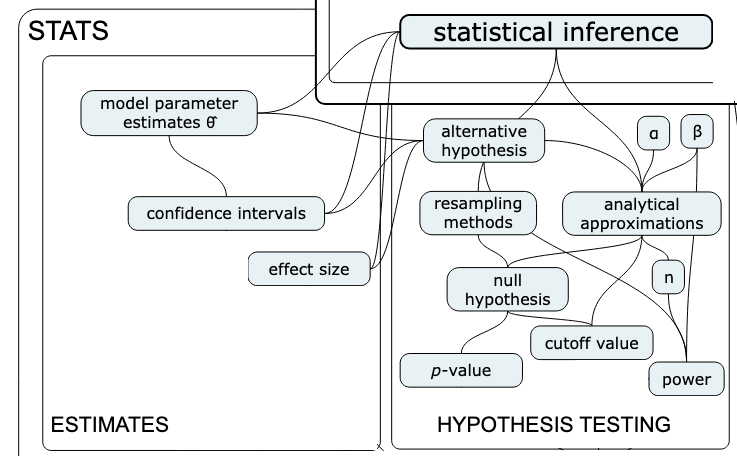


#### Notebook setup

In [1]:
# loading Python modules
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats.distributions import norm

# set random seed for repeatability
np.random.seed(42)

# notebooks figs setup
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(8,5)})
blue, orange  = sns.color_palette()[0], sns.color_palette()[1]

# silence annoying warnings
import warnings; warnings.filterwarnings('ignore')

## Overview

- Main idea = learn about a population based on a sample
- Recall Amy's two research questions about the employee lifetime value (ELV) data:
  - Question 1 = Is there a difference between ELV of the two groups? → **hypothesis testing**
  - Question 2 = How much difference in ELV does stats training provide? → **estimation**
- Inferential statistics provides us with tools to answer both of these questions

## Estimators

We'll begin our study of inferential statistics by introducing **estimators**,
which are used for both **hypothesis testing** and **estimation**.

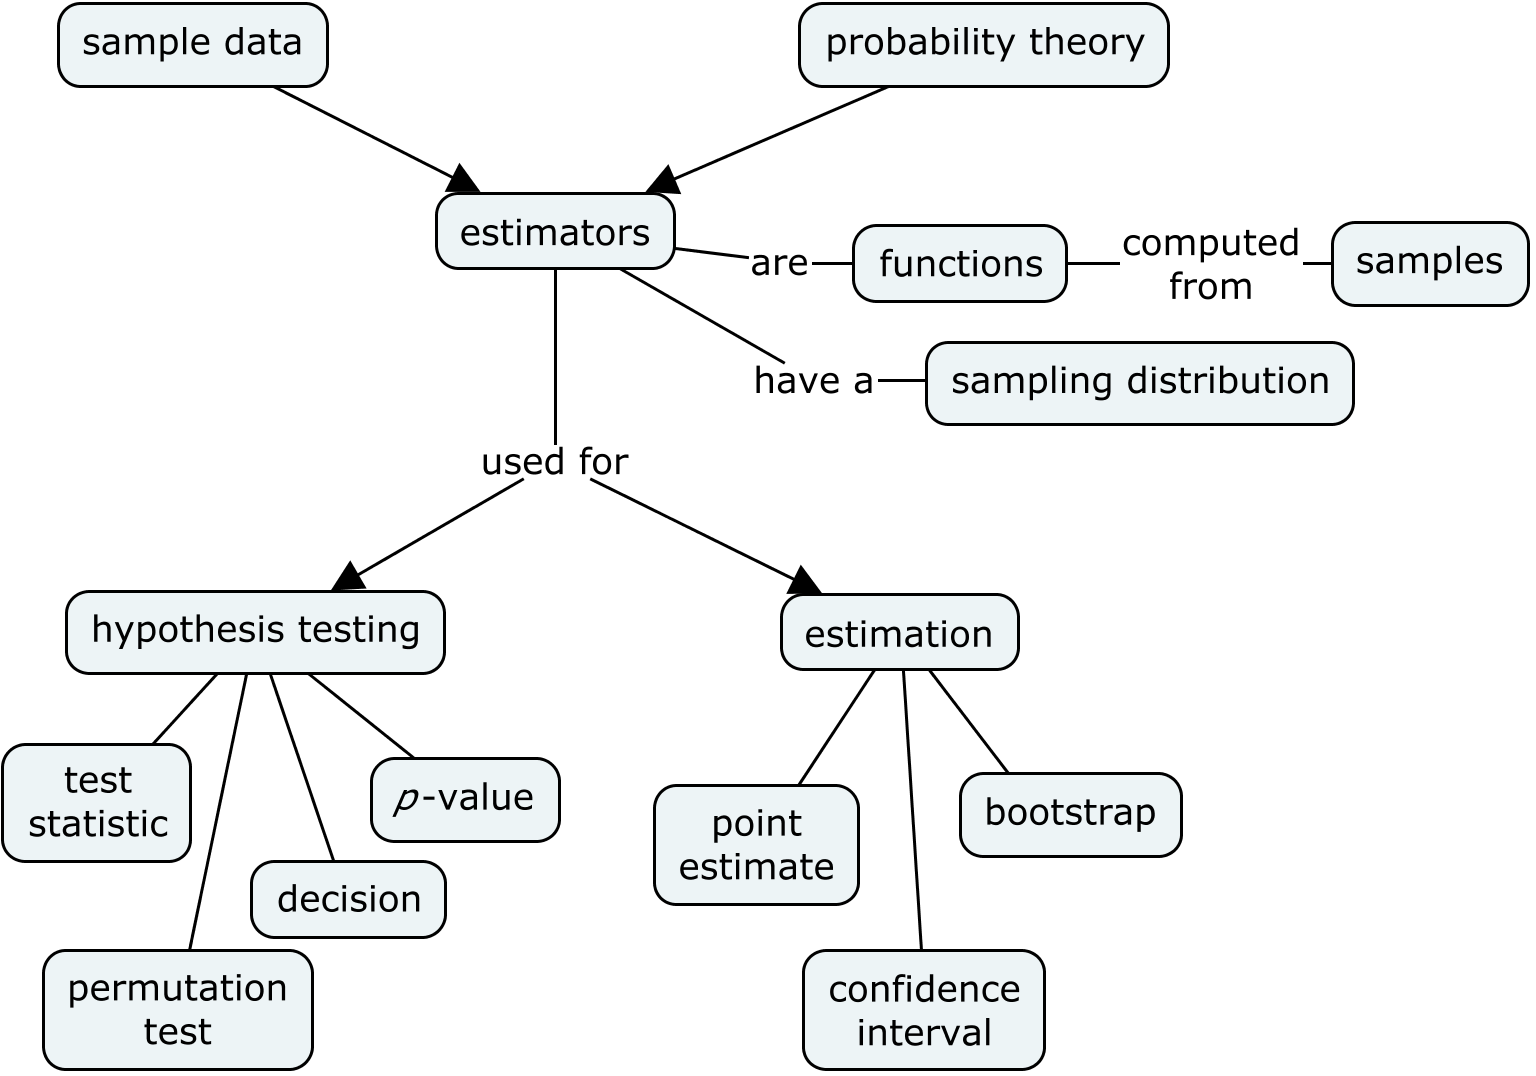


$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$

### Definitions

- We use the term "estimator" to describe a function $f$ that takes samples as inputs,
  which is written mathematically as:
  $$
   f \ \colon \underbrace{\mathcal{X}\times \mathcal{X}\times \cdots \times \mathcal{X}}_{n \textrm{ copies}}
   \quad \to \quad \mathbb{R},
  $$
  where $n$ is the samples size and $\mathcal{X}$ denotes the possible values of the random variable $X$.
- We give different names to estimators, depending on the use case:
  - **statistic** = a function computed from samples (descriptive statistics)
  - **parameter estimators** = statistics that estimates population parameters
  - **test statistic** = an estimator used as part of hypothesis testing procedure
- The **value** of the estimator $f(\mathbf{x})$ is computer from a particular sample $\mathbf{x}$.
- The **sampling distribution** of an estimator is when $f$ is the distribution of $f(\mathbf{X})$,
  where $\mathbf{X}$ is a random sample.
- Example of estimators we discussed in descriptive statistics:
  - Sample mean
    - estimator: $\overline{x} = g(\mathbf{x}) = \frac{1}{n}\sum_{i=1}^n x_i$
    - gives an estimate for the population mean $\mu$
    - sampling distribution: $\overline{X} = g(\mathbf{X}) = \frac{1}{n}\sum_{i=1}^n X_i$
  - Sample variance
    - estimator: $s^2 = h(\mathbf{x}) = \frac{1}{n-1}\sum_{i=1}^n (x_i-\overline{x})^2$
    - gives an estimate for the population variance $\sigma^2$
    - sampling distribution: $S^2 = h(\mathbf{X}) = \frac{1}{n-1}\sum_{i=1}^n (X_i-\overline{X})^2$
    
- In this notebook we focus on one estimator: **difference between group means**
    - estimator: $d = \texttt{mean}(\mathbf{x}_A) - \texttt{mean}(\mathbf{x}_{B}) = \overline{x}_{A} - \overline{x}_{B}$
    - gives an estimate for the difference between population means: $\Delta =  \mu_A - \mu_{B}$
    - sampling distribution: $D = \overline{X}_A - \overline{X}_{B}$, which is a random variable

### Difference between group means

Consider two random variables $X_A$ and $X_B$:
$$ \large
X_A \sim \mathcal{N}\!\left(\mu_A, \sigma^2_A \right)
\qquad
\textrm{and}
\qquad
X_B \sim \mathcal{N}\!\left(\mu_B, \sigma^2_B \right)
$$
that describe the probability distribution for groups A and B, respectively.

- A sample of size $n_A$ from $X_A$ is denoted $\mathbf{x}_A = x_1x_2\cdots x_{n_A}$=`xA`, and let $\mathbf{x}_B = x_1x_2\cdots x_{n_B}$=`xB` be a random sample of size $n_B$ from $X_B$.
- We compute the mean in each group: $\overline{x}_{A} = \texttt{mean}(\mathbf{x}_A)$
  and $\overline{x}_{B} = \texttt{mean}(\mathbf{x}_B)$
- The value of the estimator is $d = \overline{x}_{A} - \overline{x}_{B}$

In [2]:
def dmeans(xA, xB):
    """
    Estimator for the difference between group means.
    """
    d = np.mean(xA) - np.mean(xB)
    return d

Note the difference between group means is precisely the estimator Amy need for her analysis (**Group S** and **Group NS**). We intentionally use the labels **A** and **B** to illustrate the general case.

In [3]:
# example parameters for each group
muA, sigmaA = 300, 10
muB, sigmaB = 200, 20

# size of samples for each group
nA = 5
nB = 4

#### Particular value of the estimator `dmeans`

In [4]:
xA = norm(muA, sigmaA).rvs(nA)  # random sample from Group A
xB = norm(muB, sigmaB).rvs(nB)  # random sample from Group B

d = dmeans(xA, xB)
d

96.37484873437

The value of $d$ computed from the samples is an estimate for the difference between means of two groups: $\Delta =  \mu_A - \mu_{B}$ (which we know is $100$ in this example).

#### Sampling distribution of the estimator `dmeans`

How well does the estimate $d$ approximate the true value $\Delta$?
**What is the accuracy and variability of the estimates we can expect?**

To answer these questions, consider the random samples
$\mathbf{X}_A = X_1X_2\cdots X_{n_A}$
and $\mathbf{X}_B = X_1X_2\cdots X_{n_B}$,
then compute the **sampling distribution**: $D = \overline{X}_A - \overline{X}_{B}$.

By definition, the sampling distribution of the estimator is obtained by repeatedly generating samples `xA` and `xB` from the two distributions and computing `dmeans` on the random samples. For example, we can obtain the sampling distribution by generating $N=1000$ samples.

In [5]:
def get_sampling_dist(statfunc, meanA, stdA, nA, meanB, stdB, nB, N=1000):
    """
    Obtain the sampling distribution of the statistic `statfunc`
    from `N` random samples drawn from groups A and B with parmeters:
      - Group A: `nA` values taken from `norm(meanA, stdA)`
      - Group B: `nB` values taken from `norm(meanB, stdB)`
    Returns a list of samples from the sampling distribution of `statfunc`.
    """
    sampling_dist = [] 
    for i in range(0, N):
        xA = norm(meanA, stdA).rvs(nA)  # random sample from Group A
        xB = norm(meanB, stdB).rvs(nB)  # random sample from Group B
        stat = statfunc(xA, xB)         # evaluate `statfunc`
        sampling_dist.append(stat)      # record the value of statfunc
    return sampling_dist


In [6]:
# Generate the sampling distirbution for dmeans
dmeans_sdist = get_sampling_dist(statfunc=dmeans,
                                 meanA=muA, stdA=sigmaA, nA=nA,
                                 meanB=muB, stdB=sigmaB, nB=nB)

print("Generated", len(dmeans_sdist), "values from `dmeans(XA, XB)`")

Generated 1000 values from `dmeans(XA, XB)`


In [7]:
# first 3 values
dmeans_sdist[0:3]

[110.81313499568878, 113.02015528478827, 108.81540875963461]

#### Plot the sampling distribution of `dmeans`

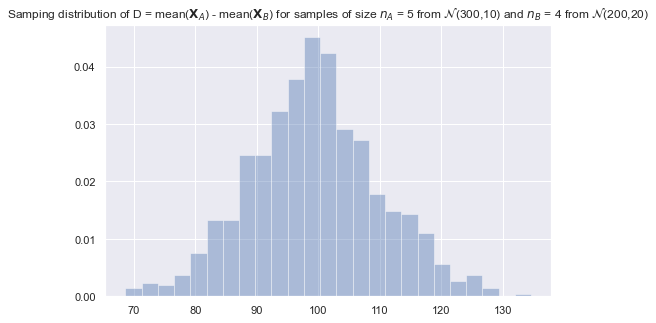

In [8]:
fig3, ax3 = plt.subplots()
title3 = "Samping distribution of D = mean($\mathbf{X}_A$) - mean($\mathbf{X}_B$) " + \
         "for samples of size $n_A$ = " + str(nA) + \
         " from $\mathcal{N}$(" + str(muA) + "," + str(sigmaA) + ")" + \
         " and $n_B$ = " + str(nB) + \
         " from $\mathcal{N}$(" + str(muB) + "," + str(sigmaB) + ")"
sns.distplot(dmeans_sdist, kde=False, norm_hist=True, ax=ax3)
_ = ax3.set_title(title3)

#### Theoretical model for the sampling distribution of `dmeans`

Let's use probability theory to build a theoretical model for the sampling distribution of the difference-between-means estimator `dmeans`.

- The central limit theorem 


the rules of  to obtain a model for the random variable $D = \overline{X}_A - \overline{X}_{B}$,
which describes the sampling distribution of  `dmeans`.

- The central limit theorem tells us the sample mean within the two group are
  $$ \large
  \overline{X}_A \sim \mathcal{N}\!\left(\mu_A, \tfrac{\sigma^2_A}{n_A} \right)
  \qquad \textrm{and} \qquad
  \overline{X}_B \sim \mathcal{N}\!\left(\mu_B, \tfrac{\sigma^2_B}{n_B} \right)
  $$

- The rules of probability theory tells us that the [difference of two normal random variables](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables#Independent_random_variables) requires subtracting their means and adding their variance, so we get:
  $$ \large
  D \sim \mathcal{N}\!\left(\mu_A - \mu_B, \  \tfrac{\sigma^2_A}{n_A} + \tfrac{\sigma^2_B}{n_B} \right)
  $$

In other words, the sampling distribution for the difference of means estimator has mean and standard deviation given by:
$$ \large
   \mu_D = \mu_A - \mu_B
   \qquad \textrm{and} \qquad
   \sigma_D = \sqrt{ \tfrac{\sigma^2_A}{n_A} + \tfrac{\sigma^2_B}{n_B}  }
$$

Let's plot the theoretical prediction on top of the simulated data to see if they are a good fit.

Probability theory predicts the sampling distribution hadmean 100 and standard deviation 10.954


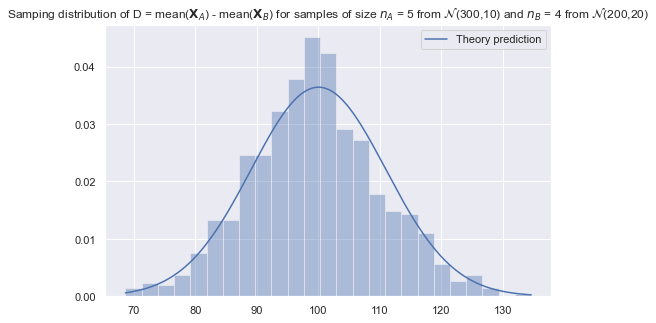

In [9]:
Dmean = muA - muB
Dstd = np.sqrt(sigmaA**2/nA + sigmaB**2/nB)
print("Probability theory predicts the sampling distribution had"
      "mean", round(Dmean, 3),
      "and standard deviation", round(Dstd, 3))

x = np.linspace(min(dmeans_sdist), max(dmeans_sdist), 10000)
D = norm(Dmean, Dstd).pdf(x)
label = 'Theory prediction'
ax3 = sns.lineplot(x, D, ax=ax3, label=label, color=blue)
fig3

### Regroup and reality check

How are you doing, dear readers?
I know this was a lot of math and a lot of code, but the good news is we're done now!
The key things to remember is that we have two ways to compute sampling distribution for any estimator:
 - Repeatedly generate random samples from model and compute the estimator values (histogram)
 - Use probability theory to obtain a analytical formula


#### Why are we doing all this modelling?

The estimator `dmeans` we defined above measures the quantity we're interested in: 
the difference between the means of two groups (**Group S** and **Group NS** in Amy's statistical analysis of ELV data).

Using the functions we developed above, we now have the ability to simulate the data from any two groups by simply choosing the appropriate parameters. In particular if we choose `stdS=266`, `nS=30`; and `stdNS=233`, `nNS=31`,
we can generate random data that has similar variability to Amy ELV measurements.

Okay, dear reader, we're about to jump into the deep end of the statistics pool: **hypothesis testing**,
which is one of the two major ideas in the STATS 101 curriculum.
Heads up this will get complicated, but we have to go into it because it is an essential procedure
that is used widely in science, engineering, business, and other types of research.
You need to trust me this one: it's worth knowing this stuff, even if it is boring.
Don't worry about it though, since you have all the prerequisites needed to get through this!


____


Recall Amy's research Question 1: 

Is there a difference between ELV of the employees in **Group S** and the employees in **Group NS**?


## Hypothesis testing

- An approach to formulating research questions as **yes-no decisions** and a **procedure for making these decisions**
- Hypothesis testing is a standardized procedure for doing statistical analysis  
  (also, using stats jargon makes everything look more convincing ;)
- We formulate research question as two **competing hypotheses**:
  - **Null hypothesis $H_0$** = no effect  
    in our example: "no difference between means," which is written as $\color{red}{\mu_S = \mu_{NS} = \mu_0}$. 
    In other words, the probability models for the two groups are:
    $$ \large
       H_0: \qquad X_S = \mathcal{N}(\color{red}{\mu_0}, \sigma_S)
       \quad \textrm{and} \quad
       X_{NS} = \mathcal{N}(\color{red}{\mu_0}, \sigma_{NS}) \quad
    $$
  - **Alternative hypothesis $H_A$** = an effect exists  
    in our example: "means for Group S different from mean for Group NS",  $\color{blue}{\mu_S} \neq \color{orange}{\mu_{NS}}$. 
    The probability models for the two groups are:
    $$ 
       H_A: \qquad X_S = \mathcal{N}(\color{blue}{\mu_S}, \sigma_S)
       \quad \textrm{and} \quad
       X_{NS} = \mathcal{N}(\color{orange}{\mu_{NS}}, \sigma_{NS})
    $$
- The purpose of hypothesis testing is to perform a basic sanity-check to show the difference between the group means
  we observed ($d = \overline{x}_{S} - \overline{x}_{NS} = 130$) is **unlikely to have occurred by chance**
- NEW CONCEPT: $p$-value is the probability of observing $d$ or more extreme under the null hypothesis.

### Overview of the hypothesis testing procedure

Here is the high-level overview of the hypothesis testing procedure:
- **inputs**: sample statistics computed from the observed data
  (in our case the signal $\overline{x}_S$, $\overline{x}_{NS}$,
   and our estimates of the noise $s^2_S$, and $s^2_{NS}$)
- **outputs**: a decision that is one of: "reject the null hypothesis" or "fail to reject the null hypothesis"

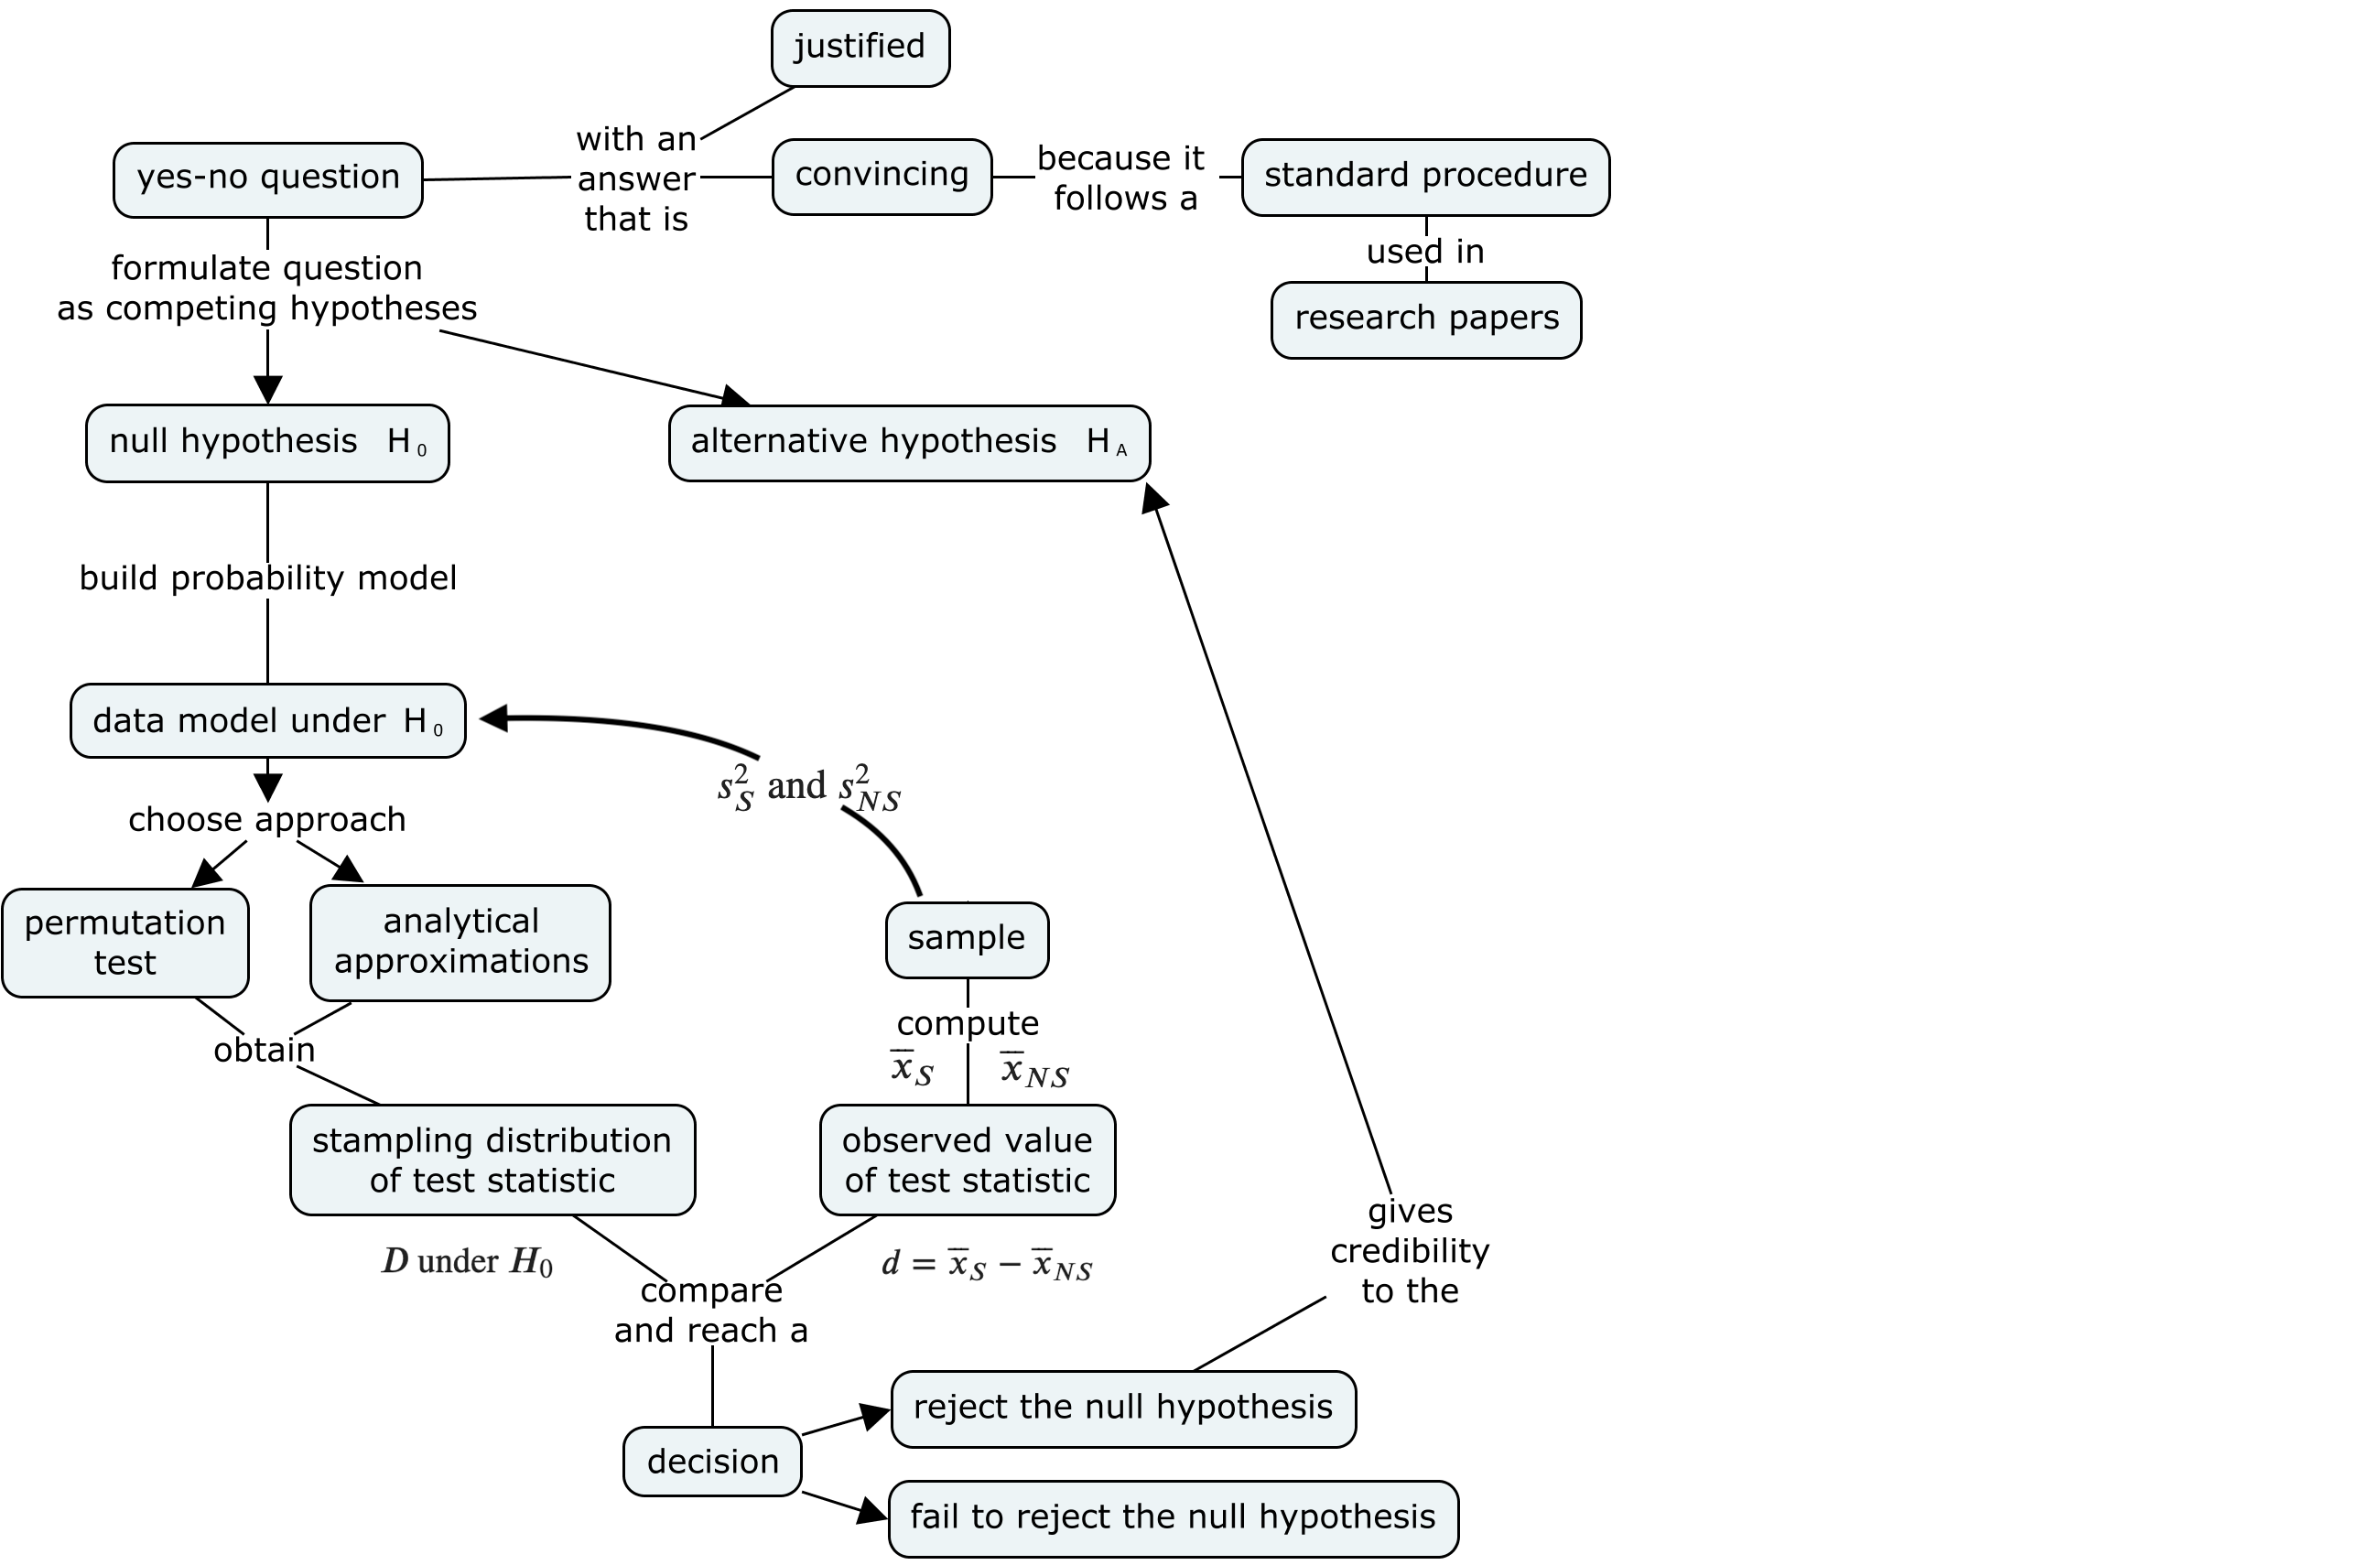

We'll now look at two different approaches for computing the sampling distribution of
the difference between group means statistic, $D = \overline{X}_S - \overline{X}_{NS}$:
permutation tests and analytical approximations.

### Interpreting the results of hypothesis testing (optional)



- The implication of rejecting the null hypothesis (no difference) is that there must is a difference between the group means.
  In other words, the ELV data for employees who took the statistics training (**Group S**) is different form
  the average ELV for employees who didn't take the statistics training (**Group NS**),
  which is what Amy is trying to show.
  - Note that rejecting null hypothesis (H0) is not the same as "proving" the alternative hypothesis (HA),
    we have just shown that the data is unlikely under the null hypothesis and we must be *some* difference between the groups,
    so is worth looking for *some* alternative hypothesis.
  - The alternative hypothesis we picked above, $\mu_S \neq \mu_{NS}$, is just a placeholder,
    that includes desirable effect: $\mu_S > \mu_{NS}$ (stats training improves ELV),
    but also includes the opposite effect: $\mu_S < \mu_{NS}$ (stats training decreases ELV).
  - Using statistics jargon, when we reject the hypothesis H0 we say we've observed a "statistically significant" result,
    which sounds a lot more impressive statement than it actually is.
    Recall hypothesis test is just used to rule out "occurred by chance," which is a very basic sanity check.    
- The implication of failing to reject the null hypothesis is that the observed difference
  between means is "not significant," meaning it could have occurred by chance,
  so there is no need to search for an alternative hypothesis.
  - Note that "failing to reject" is not the same as "proving" the null hypothesis
  - Note also "failing to reject H0" doesn't mean we reject HA.
    In fact, the alternative hypothesis didn't play any role in the calculations whatsoever.


I know all this sounds super complicated and roundabout (an it is!),
but you will get a hang of it in no time with some practice.
Trust me, you need to know this shit.


### Start by load data again...

First things first, let's reload the data which we prepared back in the DATA where we left off back in the [01_DATA.ipynb](./01_DATA.ipynb) notebook.

In [10]:
df = pd.read_csv('data/employee_lifetime_values.csv')
df

,group,ELV
0,NS,923.87
1,NS,751.38
2,NS,432.83
3,NS,1417.36
4,NS,973.24
...,...,...
56,S,931.61
57,S,1329.68
58,S,1293.03
59,S,1240.44


In [11]:
# remember the descriptive statistics
df.groupby("group").describe()

ELV                                                                  \
      count        mean         std     min        25%       50%        75%   
group                                                                         
NS     31.0  1018.41129  265.815869  432.83   858.7750   990.130  1183.2750   
S      30.0  1148.43500  233.037704  623.06  1022.1375  1119.305  1279.8825   

                
           max  
group           
NS     1620.93  
S      1716.61

In [12]:
def dmeans(sample):
    """
    Compute the difference between groups means.
    """
    xS = sample[sample["group"]=="S"]["ELV"]
    xNS = sample[sample["group"]=="NS"]["ELV"]
    d = np.mean(xS) - np.mean(xNS)
    return d

# the observed value in Amy's data
dmeans(df)

130.02370967741933

Our goal is to determine how likely or unlikely this observed value is under the null hypothesis $H_0$.

In the next two sections, we'll look at two different approaches for obtaining the sampling distribution of $D$ under $H_0$.

## Approach 1: Permutation test for hypothesis testing

- The permutation test allow us to reject $H_0$ using existing sample $\mathbf{x}$ that we have,
  treating the sample as if it were a population.
- Relevant probability distributions:
  - Sampling distribution = obtained from repeated samples from a hypothetical population under $H_0$.
  - Approximate sampling distribution: obtained by **resampling data from the single sample we have**.
- Recall Goal 1: make sure data cannot be explained by $H_0$ (observed difference due to natural variability)
  - We want to obtain an approximation of the sampling distribution under $H_0$
  - The $H_0$ probability model describes a hypothetical scenario with **no difference between groups**,
    which means data from **Group S** and **Group NS** comes the same distribution.
  - To generate a new random sample $\mathbf{x}^p$ from $H_0$ model we can reuse the sample we have obtained $\mathbf{x}$, but randomly mix-up the group labels. Since under the $H_0$ model, the **S** and **NS** populations are identical, mixing up the labels should have no effect.
  - The math term for "mixing up" is **permutation**, meaning 
    each value is input is randomly reassigned to a new random place in the output.

In [13]:
def resample_under_H0(sample, groupcol="group"):
    """
    Return a copy of the dataframe `sample` with the labels in the column `groupcol`
    modified based on a random permutation of the values in the original sample.
    """
    resample = sample.copy()
    labels = sample[groupcol].values
    newlabels = np.random.permutation(labels)
    resample[groupcol] = newlabels
    return resample

resample_under_H0(df)

,group,ELV
0,S,923.87
1,NS,751.38
2,S,432.83
3,NS,1417.36
4,NS,973.24
...,...,...
56,S,931.61
57,NS,1329.68
58,NS,1293.03
59,S,1240.44


In [14]:
# resample
resample = resample_under_H0(df)

# compute the difference in means for the new labels
dmeans(resample)

-29.60082795698918

The steps in the above code cell give us a simple way to generate samples from the null hypothesis and compute the value of `dmeans` statistic for these samples. We used the assumption of "no difference" under the null hypothesis, and translated this to the "forget the labels" interpretation.

#### Running a permutation test

We can repeat the resampling procedure `10000` times to get the sampling distribution of $D$ under $H_0$,
as illustrated in the code procedure below.

In [15]:
def permutation_test(sample, statfunc, groupcol="group", permutations=10000):
    """
    Compute the p-value of the observed `statfunc(sample)` under the null hypothesis
    where the labels in the `groupcol` are randomized.
    """
    # 1. compute the observed value of the statistic for the sample
    obsstat = statfunc(sample)

    # 2. generate the sampling distr. using random permutations of the group labels
    resampled_stats = []
    for i in range(0, permutations):
        resample = resample_under_H0(sample, groupcol=groupcol)
        restat = statfunc(resample)
        resampled_stats.append(restat)

    # 3. compute p-value: how many `restat`s are equal-or-more-extreme than `obsstat`
    tailstats = [restat for restat in resampled_stats \
                 if restat <= -abs(obsstat) or restat >= abs(obsstat)]
    pvalue = len(tailstats) / len(resampled_stats)

    return resampled_stats, pvalue


sampling_dist, pvalue = permutation_test(df, statfunc=dmeans)

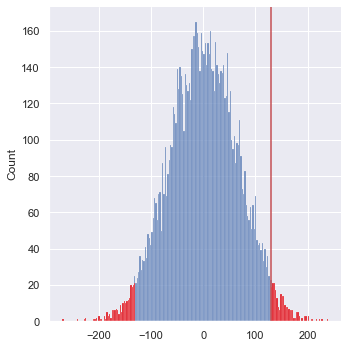

In [16]:
# plot the sampling distribution in blue
sns.displot(sampling_dist, bins=200)

# plot red line for the observed statistic
obsstat = dmeans(df)
plt.axvline(obsstat, color='r')

# plot the values that are equal or more extreme in red
tailstats = [rs for rs in sampling_dist if rs <= -obsstat or rs >= obsstat]
_ = sns.histplot(tailstats, bins=200, color="red")

- Once we have the sampling distribution of `D` under $H_0$,
  we can see where the observed value $d=130$
  falls within this distribution.
- p-value: the probability of observing value $d$ or more extreme under the null hypothesis

In [17]:
pvalue

0.046

We can now make the decision based on the $p$-value and a pre-determined threshold:
- If the observed value $d$ is unlikely under $H_0$ ($p$-value less than 5% chance of occurring),
  then our decision will be to "reject the null hypothesis."
- Otherwise, if the observed value $d$ is not that unusual ($p$-value greater than 5%),
  we conclude that we have "failed to reject the null hypothesis."

In [18]:
if pvalue < 0.05:
    print("DECISION: Reject H0", "( p-value =", pvalue, ")")
    print("          There is a statistically significant difference between xS and xNS means")
else:
    print("DECISION: Fail to reject H0")
    print("          The difference between groups means could have occurred by chance")    

DECISION: Reject H0 ( p-value = 0.046 )
          There is a statistically significant difference between xS and xNS means


#### Permutations test using SciPy

The above code was given only for illustrative purposes.
In practice, you can use the SciPy implementation of permutation test,
by calling `ttest_ind(..., permutations=10000)` to perform a permutation test, then obtain the $p$-value.

In [19]:
from scipy.stats import ttest_ind

xS = df[df["group"]=="S"]["ELV"]
xNS = df[df["group"]=="NS"]["ELV"]

ttest_ind(xS, xNS, permutations=10000).pvalue

0.0447

#### Discussion

  - The procedure we used is called a **permutations test** for comparison of group means.
  - The permutation test takes it's name from the action of mixing up the group-membership labels
    and computing a statistic which is a way to generate samples from the null hypothesis
    in situations where we're comparing two groups.
  - Permutation tests are very versatile since we can use them for any estimator $h(\mathbf{x})$.
    For example, we could have used difference in medians by specifying the `median` as the input `statfunc`.


## Approach 2: Analytical approximations for hypothesis testing

We'll now look at another approach for answering Question 1:
using and analytical approximation,
which is the way normally taught in STATS 101 courses.
How likely or unlikely is the observed difference $d=130$ under the null hypothesis?

- Analytical approximations are math models for describing the sampling distribution under $H_0$
  - Sampling distributions = obtained by repeated sampling from $H_0$
  - Analytical approximation = probability distribution model based on estimated parameters
- Assumption: population is normally distributed
- Based on this assumption we can use the theoretical model we developed above for difference between group means
  to obtain a **closed form expression** for the sampling distribution of $D$
- In particular, the probability model for the two groups under $H_0$ are:
  $$ \large
       H_0: \qquad X_S = \mathcal{N}(\color{red}{\mu_0}, \sigma_S)
       \quad \textrm{and} \quad
       X_{NS} = \mathcal{N}(\color{red}{\mu_0}, \sigma_{NS}), \quad
  $$
  from which we can derive the model for $D = \overline{X}_S - \overline{X}_{NS}$:
  $$ \large
     D  \sim \mathcal{N}\!\left( \color{red}{0}, \  \tfrac{\sigma^2_S}{n_S} + \tfrac{\sigma^2_{NS}}{n_{NS}} \right)
  $$
  In words, the sampling distribution of the difference between group means is
  normally distributed with mean $\mu_D = 0$ and variance $\sigma^2_D$ dependent
  on the variance of the two groups $\sigma^2_S$ and $\sigma^2_{NS}$.
  Recall we obtained this expression earlier when we discussed difference of means between groups A and B.
- However, the population variances are unknown $\sigma^2_S$ and $\sigma^2_{NS}$,
  and we only have the estimated variances $s_S^2$ and $s_{NS}^2$ calculated from the sample.
- That's OK though, since sample variances are good approximation to the population variances.
  There are two common ways to obtain an approximation for $\sigma^2_D$:
  - Pooled variance: $\sigma^2_D \approx s^2_p =  \frac{(n_S-1)s_S^2 \; + \; (n_{NS}-1)s_{NS}^2}{n_S + n_{NS} - 2}$
    (takes advantage of assumption that both samples come from the same population under $H_0$)
  - Unpooled variance: $\sigma^2_D \approx s^2_u = \tfrac{s^2_S}{n_S} + \tfrac{s^2_{NS}}{n_{NS}}$
    (follows from general rule of prob theory)
- NEW CONCEPT: **Student's $t$-distribution** is a model for $D$ which takes into account
  we are using $s_S^2$ and $s_{NS}^2$ instead of $\sigma_S^2$ and $\sigma_{NS}^2$.
- NEW CONCEPT: **degrees of freedom**, denoted `dof` in code or $\nu$ (Greek letter *nu*) in equations,
  is the parameter Student's $t$ distribution related to the sample size used to estimate quantities.


### Student's t-test (pooled variance)

[Student's t-test for comparison of difference between groups means](https://statkat.com/stattest.php?&t=9),
is a procedure that makes use of the pooled variance $s^2_p$.

#### Black-box approach
The `scipy.stats` function `ttest_ind` will perform all the steps of the $t$-test procedure,
without the need for us to understand the details.

In [20]:
from scipy.stats import ttest_ind

# extract data for two groups
xS = df[df["group"]=="S"]['ELV']
xNS = df[df["group"]=="NS"]['ELV']

# run the complete t-test procedure for ind-ependent samples:
result = ttest_ind(xS, xNS)
result.pvalue

0.046999086677830995

The $p$-value is less than 0.05 so our decision is to **reject the null hypothesis**.

#### Student's t-test under the hood

The computations hidden behind the function `ttest_ind` involve a six step procedure that makes use of the pooled variance $s^2_p$.

In [21]:
from statistics import stdev
from scipy.stats.distributions import t

# 1. calculate the mean in each group
meanS, meanNS = np.mean(xS), np.mean(xNS)

# 2. calculate d, the observed difference between means
d = meanS - meanNS

# 3. calculate the standard deviations in each group
stdS, stdNS = stdev(xS), stdev(xNS)
nS, nNS = len(xS), len(xNS)

# 4. compute the pooled variance and standard error
var_pooled = ((nS-1)*stdS**2 + (nNS-1)*stdNS**2)/(nS + nNS - 2)
std_pooled = np.sqrt(var_pooled)
std_err =  np.sqrt(std_pooled**2/nS + std_pooled**2/nNS)

# 5. compute the value of the t-statistic
tstat = d / std_err

# 6. obtain the p-value for the t-statistic from a 
#    t-distribution with 31+30-2 = 59 degrees of freedom
dof = nS + nNS - 2
pvalue = 2 * t(dof).cdf(-abs(tstat))  # 2* because two-sided

pvalue

0.046999086677830995

#### Welch's t-test (unpooled variances)

An [alternative t-test procedure](https://statkat.com/stattest.php?&t=9) that doesn't assume the variances in groups are equal.

In [22]:
result2 = ttest_ind(xS, xNS, equal_var=False)
result2.pvalue

0.046579019827041344

Welch's $t$-test differs only in steps 4 through 6 as shown below:

In [23]:
# 4'. compute the unpooled standard deviation of D
stdD = np.sqrt(stdS**2/nS + stdNS**2/nNS)

# 5'. compute the value of the t-statistic
tstat = d / stdD

# 6'. obtain the p-value from a t-distribution with
#     (insert crazy formula here) degrees of freedom
dof = (stdS**2/nS + stdNS**2/nNS)**2 / \
    ((stdS**2/nS)**2/(nS-1) + (stdNS**2/nNS)**2/(nNS-1) )
pvalue = 2 * t(dof).cdf(-abs(tstat))  # 2* because two-sided

pvalue

0.04657901982704139

### Summary of Question 1

We saw two ways to answer Question 1 (is there a difference between group means) and obtain the p-value.
We interpreted the small p-values as evidence that the observed difference, $d=130$, is unlikely to be due to chance,
i.e. we rejected the null hypothesis.
Note this whole procedure is just a sanity check—we haven't touched the alternative hypothesis at all yet,
and for all we know the stats training could have the effect of decreasing ELV!


 
____

It's time to study Question 2, which is to estimate the magnitude of the change in ELV obtained from completing the stats training, which is called *effect size* in statistics.

## Estimating the effect size

- Question 2 of statistical analysis is to estimate the difference in ELV gained by stats training.
- NEW CONCEPT: **effect size** is a measure of difference between intervention and control groups.
- We assume the data of **Group S** and **Group NS** come from different populations with means $\mu_S$ and $\mu_{NS}$
- We're interested in the difference between population means, denoted $\Delta = \mu_S - \mu_{NS}$.
- By analyzing the sample, we have obtained an estimate $d=130$ for the unknown $\Delta$,
  but we know our data contains lots of variability, so we know our estimate might be off.
- We want an answer to Question 2 (What is the estimated difference between group means?)
  that takes into account the variability of the data.
- NEW CONCEPT: **confidence interval** is a way to describe a range of values for an estimate
- We want to provide an answer to Question 2 in the form of a confidence interval that tells
  us a range of values where we believe the true value of $\Delta$ falls.
- Similar to how we showed to approaches for hypothesis testing,
  we'll work on effect size estimation using two approaches: resampling methods and analytical approximations.


### Approach 1: estimate the effect size using bootstrap method

- We want to estimate the distribution of ELV values for the two groups,
  and compute the difference between the means of these distributions.
- Distributions:
  - Sampling distributions = obtained by repeated sampling from the populations
  - Bootstrap sampling distributions = resampling data from the samples we have (with replacement)
- Intuition: treat the samples as if they were the population
- We'll compute $B=5000$ bootstrap samples from the two groups and compute the difference,
  then look at the distribution of the bootstrap sample difference to obtain $CI_{\Delta}$,
  the confidence interval for the difference between population means.

In [24]:
from statistics import mean

def bootstrap_stat(sample, statfunc=mean, B=5000):
    """
    Compute the bootstrap estimate of the function `statfunc` from the sample.
    Returns a list of statistic values from bootstrap samples.
    """
    n = len(sample)
    bstats = []
    for i in range(0, B):
        bsample = np.random.choice(sample, n, replace=True)
        bstat = statfunc(bsample)
        bstats.append(bstat)
    return bstats


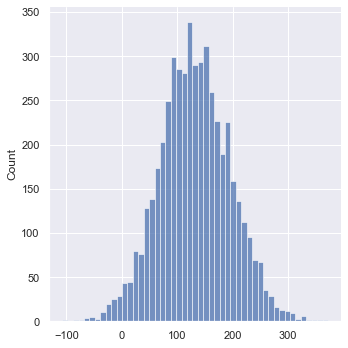

In [25]:
# load data for two groups
df = pd.read_csv('data/employee_lifetime_values.csv')
xS = df[df["group"]=="S"]['ELV']
xNS = df[df["group"]=="NS"]['ELV']

# compute bootstrap estimates for mean in each group
meanS_bstats = bootstrap_stat(xS, statfunc=mean)
meanNS_bstats = bootstrap_stat(xNS, statfunc=mean)

# compute the difference between means from bootstrap samples
dmeans_bstats = []
for bmeanS, bmeanNS in zip(meanS_bstats, meanNS_bstats):
    d = bmeanS - bmeanNS 
    dmeans_bstats.append(d)

sns.displot(dmeans_bstats)

In [26]:
# 90% confidence interval for the difference in means
CI_boot = [np.percentile(dmeans_bstats, 5), np.percentile(dmeans_bstats, 95)]
CI_boot

[28.3957801075268, 237.55493602150537]

#### SciPy bootstrap method

In [27]:
from scipy.stats import bootstrap

def dmeans2(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

res = bootstrap((xS, xNS), statistic=dmeans2, vectorized=False,
                confidence_level=0.9, n_resamples=5000, method='percentile')

CI_boot2 = [res.confidence_interval.low, res.confidence_interval.high]
CI_boot2

[26.55480537634374, 234.32339731182762]

### Approach 2: Estimates using analytical approximation method

  - Assumption 1: populations for **Group S** and **Group NS** are normally distributed
  - Assumption 2: the variance of the two populations is the same (or approximately equal)
  - Using the theoretical model for the populations,
    we can obtain a formula for CI of effect size $\Delta$:
    $$
    \textrm{CI}_{(1-\alpha)}
    = \left[ d - t^*\!\cdot\!\sigma_D, \, 
             d + t^*\!\cdot\!\sigma_D
      \right].
    $$
    The confidence interval is centred at $d$,
    with width proportional to the standard deviation $\sigma_D$.
    The constant $t^*$ denotes the value of the inverse CDF of Student's $t$-distribution
    with appropriate number of degrees of freedom `dof` evaluated at $1-\frac{\alpha}{2}$.
    For a 90% confidence interval, we choose $\alpha=0.10$,
    which gives $(1-\frac{\alpha}{2}) = 0.95$, $t^* = F_{T_{\textrm{dof}}}^{-1}\left(0.95\right)$.
  - We can use the two different analytical approximations to obtain a formula for $\sigma_D$
    just as we did in the hypothesis testing:
    - Pooled variance: $\sigma^2_p =  \frac{(n_S-1)s_S^2 + (n_{NS}-1)s_{NS}^2}{n_S + n_{NS} - 2}$,
      and `dof` = $n_S + n_{NS} -2$
    - Unpooled variance: $\sigma^2_u = \tfrac{s^2_A}{n_A} + \tfrac{s^2_B}{n_B}$, and `dof` = [...](https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_or_unequal_sample_sizes,_unequal_variances_(sX1_%3E_2sX2_or_sX2_%3E_2sX1))

#### Using pooled variance

The calculations are similar to Student's t-test for hypothesis testing.

In [28]:
from scipy.stats.distributions import t

d = np.mean(xS) - np.mean(xNS)

nS, nNS = len(xS), len(xNS)
stdS, stdNS = stdev(xS), stdev(xNS)
var_pooled = ((nS-1)*stdS**2 + (nNS-1)*stdNS**2)/(nS + nNS - 2)
std_pooled = np.sqrt(var_pooled)
std_err = std_pooled * np.sqrt(1/nS + 1/nNS)

dof = nS + nNS - 2

# for 90% confidence interval, need 10% in tails
alpha = 0.10

# now use inverse-CDF of Students t-distribution
tstar = abs(t(dof).ppf(alpha/2))

CI_tpooled = [d - tstar*std_err, d + tstar*std_err]
CI_tpooled

[22.925130302086643, 237.12228905275202]

#### Using unpooled variance

The calculations are similar to the Welch's t-test for hypothesis testing.

In [29]:
d = np.mean(xS) - np.mean(xNS)

nS, nNS = len(xS), len(xNS)
stdS, stdNS = stdev(xS), stdev(xNS)
stdD = np.sqrt(stdS**2/nS + stdNS**2/nNS)

dof = (stdS**2/nS + stdNS**2/nNS)**2 / \
    ((stdS**2/nS)**2/(nS-1) + (stdNS**2/nNS)**2/(nNS-1) )

# for 90% confidence interval, need 10% in tails
alpha = 0.10

# now use inverse-CDF of Students t-distribution
tstar = abs(t(dof).ppf(alpha/2))

CI_tunpooled = [d - tstar*stdD, d + tstar*stdD]
CI_tunpooled

[23.14219839967336, 236.9052209551653]

#### Summary of Question 2 results

We now have all the information we need to give a precise and nuanced answer to Question 2: "How big is the increase in ELV produced by stats training?".

The basic estimate of the difference is $130$ can be reported, and additionally can can report the 90% confidence interval for the difference between group means, that takes into account the variability in the data we have observed.

Note the CIs obtained using different approaches are all similar (+/- 5 ELV points), so it doesn't matter much which approach we use:

In [30]:
CI_boot, CI_boot2, CI_tpooled, CI_tunpooled

([28.3957801075268, 237.55493602150537],
 [26.55480537634374, 234.32339731182762],
 [22.925130302086643, 237.12228905275202],
 [23.14219839967336, 236.9052209551653])

### Standardized effect size (optional)

It is sometimes useful to report the effect size using a "standardized" measure for effect sizes.
*Cohen's $d$* one such measure, and it is defined as the difference between two means divided by the pooled  standard deviation.

In [31]:
def cohend(sample1, sample2):
    """
    Compute Cohen's d measure of effect size for two independent samples.
    """
    n1, n2 = len(sample1), len(sample2)
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    # calculate the pooled variance and standard deviaiton
    var_pooled = ((n1-1)*var1 + (n2-1)*var2) / (n1 + n2 - 2)
    std_pooled = np.sqrt(var_pooled)
    # compute Cohen's d
    cohend = (mean1 - mean2) / std_pooled
    return cohend

cohend(xS, xNS)

0.5195925482978414

We can interpret the value of Cohen's d obtained using the [reference table](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d) of values:

| Cohen's d   | Effect size |
| ----------- | ----------- |
| 0.01        | very small  |
| 0.20        | small       |
| 0.50        | medium      |
| 0.80        | large       |

We can therefore say the effect size of offering statistics training for employees has an **medium** effect size.

## Conclusion of Amy's statistical analysis

Recall the two research questions that Amy set out to answer in the beginning of this video series:
- Question 1: Is there a difference between the means in the two groups?
- Question 2: How much does statistics training improve the ELV of employees?

The statistical analysis we did allows us to answer these two questions as follows:
- Answer 1: There is a statistically significant difference between Group S and Group NS, p = 0.048.
- Answer 2: The estimated improvement in ELV is 130 points, which is corresponds to Cohen's d value of 0.52 (medium effect size). A 90% confidence interval for the true effect size is [25.9, 234.2].

Note: we used the numerical results obtained from resampling methods (Approach 1), but conclusions would be qualitatively the same if we reported results obtained from analytical approximations (Approach 2).


### Using statistics for convincing others

You may be wondering if all this probabilistic modelling and complicated statistical analysis was worth it to reach a conclusion that seems obvious in retrospect. Was all this work worth it? The purpose of all this work is to obtains something close to an objective conclusion. Without statistics it is very easy to fool ourselves and interpret patterns in data the way we want to, or alternatively, not see patterns that are present. By following the standard statistical procedures, we're less likely to fool ourselves, and more likely to be able to convince others.

It can very useful to imagine Amy explaining the results to a skeptical colleague. Suppose the colleague is very much against the idea of statistical training, and sees it as a distraction, saying things like "We hire employees to do a job, not to play with Python." and "I don't know any statistics and I'm doing my job just fine!" You get the picture.

Imagine Amy presenting her findings about how 100 hours of statistical training improves employee lifetime value (ELV) results after one year, and suggesting the statistical training be implemented for all new hires from now on. The skeptical colleague immediately rejects the idea and questions Amy's recommendation using emotional arguments like about necessity, time wasting, and how statistics is a specialty topic that is not required for all employees. Instead of arguing based on opinions and emotions with her colleague, Amy explains her recommendation is based on a statistical experiment she conducted, and shows the results.

- When the colleague asks if the observed difference could be due to chance, Amy says that this is unlikely, and quotes the p-value of 0.048 (less than 0.05), and interprets the result as saying the probability of observed difference between **Group S** and **Group NS** to be due to chance is less than 5%.

- The skeptical colleague is forced to concede that statistical training does improve ELV, but then asks about the effect size of the improvement: "How much more ELV can we expect if we provide statistics training?" Amy is ready to answer quoting the observed difference of $130$ ELV points, and further specifies the 90% confidence interval of [25.9, 234.2] for the improvement, meaning in the worst case there is 25 ELV points improvement.

The skeptic is forced to back down from their objections, and the "stats training for all" program is adopted in the company. Not only was Amy able to win the argument using statistics, but she was also able to set appropriate expectations for the results. In other words, she hasn't promised a guaranteed +130 ELV improvement, but a realistic range of values that can be expected.


## Comparison of resampling methods and analytical approximations

In this notebook we saw two different approaches for doing statistical analysis: resampling methods and analytical approximations. This is a general pattern in statistics where there is not only one correct answer: multiple approaches to data analysis are valid, and you need to think about the specifics of each data analysis situation. You'll learn about both approaches in the book.

Analytical approximations currently taught in most stats courses (STAT 101). Historically, analytical approximations have been used more widely because they require only simple arithmetic calculations: statistic practitioners (scientists, engineers, etc.) simply need to compute sample statistics, plug them into a formula, and obtain a $p$-value. This convenience is at the cost of numerous assumptions about the data distribution, which often don't hold in practice (e.g. assuming population is normal, when it is isn't).

In recent years, resampling methods like the permutation test and bootstrap estimation are becoming more popular and widely in industry, and increasingly also taught at to university students (*modern statistics*). **The main advantage so resampling methods is that they require less modelling assumptions.** Procedures like the permutation test can be applied broadly to any scenarios where two groups are compared, and don't require developing specific formulas for different cases. Resampling methods are easier to understand since the statistical procedure they require are directly related to the sampling distribution, and there are no formulas to memorize.

Understanding resampling methods requires some basic familiarity with programming, but the skills required are not advanced: knowledge of variables, expressions, and basic `for` loop is sufficient. If you were able to follow the code examples described above (see `resample_under_H0`, `permutation_test`, and `bootstrap_stat`), then you've already **seen all the code you will need for the entire book!**

## Other statistics topics in the book

The goal of this notebook was to focus on the two main ideas of inferential statistics ([Chapter 3](https://docs.google.com/document/d/1fwep23-95U-w1QMPU31nOvUnUXE2X3s_Dbk5JuLlKAY/edit#heading=h.uutryzqeo2av)): hypothesis testing and estimation. We didn't have time to cover many of the other important topics in statistics, which will be covered in the book (and in future notebooks). Here is a list of some of these topics:

- Null Hypothesis Significance Testing (NHST) procedure in full details (Type I and Type II error, power, sample size calculations) 
- Statistical assumptions behind analytical approximations
- Cookbook of statistical analysis recipes (analytical approximations for different scenarios)
- Experimental design (how to plan and conduct statistical experiments)
- Misuses of statistics (caveats to watch out for and mistakes to avoid)
- Bayesian statistics (very deep topic; we'll cover only main ideas)
- Practice problems and exercises (real knowledge is when you can do the calculations yourself)

___

So far our statistical analysis was limited to comparing two groups, which is referred to as **categorical predictor variable** using stats jargon. In the next notebook we'll learn about statistical analysis with **continuous predictor variables**: instead of comparing stats vs. no-stats, we analyze what happens when variable amount of stats training is provided (a continuous predictor variable).

Open the notebook [04_LINEAR_MODELS.ipynb](./04_LINEAR_MODELS.ipynb) when you're ready to continue.

In [32]:
code = list(["um"])